# Base Model Componenets


## Imports

In [1]:
!pip install torchvision
from torchvision import datasets
from torchvision import transforms
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.cluster import normalized_mutual_info_score

## Function to show images



In [2]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


## Function to regenerate an image from a given image

In [3]:
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size))
    except:
        out, _, _ = model(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)


## Function to generate an image from an arbitary distribution.

In [4]:
def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

## Configuretions



In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Dataset Loading

In [6]:
# Specify data directory
data_dir = 'data'

# Fashion-MNIST dataset
dataset  = datasets.FashionMNIST(root=data_dir, train=True, download=True,
                                  transform=transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root=data_dir, train=False, download=True,
                                  transform=transforms.ToTensor())

# Data loaders (adjust batch size as needed)
data_loader  = torch.utils.data.DataLoader(dataset=dataset , batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

# Now you have access to the Fashion-MNIST dataset through train_loader and test_loader

## VAE Architecture

In [7]:

# VAE model
class VAE_3(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE_3, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


## Create VAE model

In [8]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

model_3 = VAE_3().to(device)
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

## Train the model

In [9]:
final_losses_3 = []
# Start training
for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model_3(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))
    
    final_losses_3.append(epoch_loss / len(data_loader.dataset))

Epoch[1/15], Step [10/469], Reconst Loss: 411.7032, KL Div: 7.9749
Epoch[1/15], Step [20/469], Reconst Loss: 363.1300, KL Div: 11.5699
Epoch[1/15], Step [30/469], Reconst Loss: 339.9929, KL Div: 10.8628
Epoch[1/15], Step [40/469], Reconst Loss: 313.4241, KL Div: 12.0210
Epoch[1/15], Step [50/469], Reconst Loss: 314.2811, KL Div: 11.5344
Epoch[1/15], Step [60/469], Reconst Loss: 292.0201, KL Div: 13.6597
Epoch[1/15], Step [70/469], Reconst Loss: 303.8240, KL Div: 11.7697
Epoch[1/15], Step [80/469], Reconst Loss: 285.4048, KL Div: 12.3266
Epoch[1/15], Step [90/469], Reconst Loss: 283.5287, KL Div: 13.1143
Epoch[1/15], Step [100/469], Reconst Loss: 275.3129, KL Div: 13.1742
Epoch[1/15], Step [110/469], Reconst Loss: 287.6639, KL Div: 13.1089
Epoch[1/15], Step [120/469], Reconst Loss: 266.8202, KL Div: 14.7462
Epoch[1/15], Step [130/469], Reconst Loss: 253.3880, KL Div: 14.3848
Epoch[1/15], Step [140/469], Reconst Loss: 263.6403, KL Div: 14.7452
Epoch[1/15], Step [150/469], Reconst Loss: 2

## Show generation

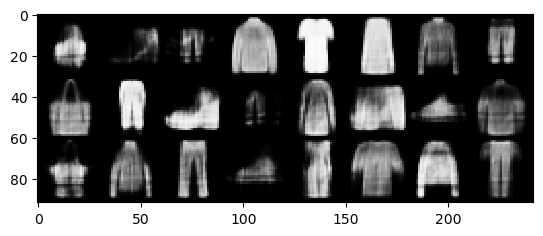

In [68]:
plot_generation(model_3)

## Show Reconstraction

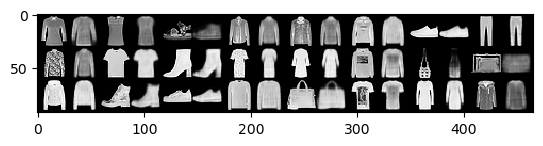

In [69]:
plot_reconstruction(model_3)

# Tasks

## a.
### Change the base three layer model into a four layer model

In this task you need to modify the VAE class and convert it into a four layer class

In [10]:
# Change the VAE class
import torch
from torch import nn
from torch.nn import functional as F

class VAE4Layer(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, intermediate_dim=256):
        super(VAE4Layer, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc_intermediate_e = nn.Linear(h_dim, intermediate_dim)  # Additional intermediate layer in encoder
        self.fc2 = nn.Linear(intermediate_dim, z_dim)  # Maps intermediate representation to mean of latent space
        self.fc3 = nn.Linear(intermediate_dim, z_dim)  # Maps intermediate representation to log-variance of latent space

        # Decoder
        self.fc4 = nn.Linear(z_dim, intermediate_dim)  # Additional intermediate layer in decoder
        self.fc_intermediate_d = nn.Linear(intermediate_dim, h_dim)  # Maps back to h_dim
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc_intermediate_e(h))  # Pass through the additional intermediate layer
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc_intermediate_d(h))  # Pass through the additional intermediate layer
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, image_size))  # Ensure x is flattened if necessary
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [12]:
# Create new model

# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
intermediate_dim = 256
num_epochs = 15
learning_rate = 1e-3

model_4 = VAE4Layer().to(device)
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

In [19]:
# Train new model
# Start training
final_losses_4 = []
bad_image_original = None
bad_image_reconst = None
best_image_original = None
best_image_reconst = None

reconst_min = None
reconst_max = None

for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model_4(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        if(reconst_min == None):
            reconst_min = reconst_loss.item()/len(x)
            best_image_original = x
            best_image_reconst = x_reconst
        elif(reconst_loss.item()/len(x) < reconst_min):
            reconst_min = reconst_loss.item()/len(x)
            best_image_original = x
            best_image_reconst = x_reconst

        if(reconst_max == None):
            reconst_max = reconst_loss.item()/len(x)
            bad_image_original = x
            bad_image_reconst = x_reconst
        elif(reconst_loss.item()/len(x) > reconst_max):
            reconst_max = reconst_loss.item()/len(x)
            bad_image_original = x
            bad_image_reconst = x_reconst
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))
    
    final_losses_4.append(epoch_loss / len(data_loader.dataset))
print(reconst_min)
print(reconst_max)

Epoch[1/15], Step [10/469], Reconst Loss: 219.4400, KL Div: 12.8194
Epoch[1/15], Step [20/469], Reconst Loss: 216.5881, KL Div: 13.1302
Epoch[1/15], Step [30/469], Reconst Loss: 205.7785, KL Div: 13.3398
Epoch[1/15], Step [40/469], Reconst Loss: 214.8843, KL Div: 13.6802
Epoch[1/15], Step [50/469], Reconst Loss: 228.9208, KL Div: 12.6370
Epoch[1/15], Step [60/469], Reconst Loss: 216.0513, KL Div: 13.6741
Epoch[1/15], Step [70/469], Reconst Loss: 225.5044, KL Div: 13.4103
Epoch[1/15], Step [80/469], Reconst Loss: 229.0121, KL Div: 13.0750
Epoch[1/15], Step [90/469], Reconst Loss: 220.3345, KL Div: 13.2933
Epoch[1/15], Step [100/469], Reconst Loss: 216.2614, KL Div: 13.4286
Epoch[1/15], Step [110/469], Reconst Loss: 223.6828, KL Div: 13.7313
Epoch[1/15], Step [120/469], Reconst Loss: 213.4437, KL Div: 12.9949
Epoch[1/15], Step [130/469], Reconst Loss: 232.9468, KL Div: 12.8997
Epoch[1/15], Step [140/469], Reconst Loss: 210.9602, KL Div: 13.8256
Epoch[1/15], Step [150/469], Reconst Loss: 

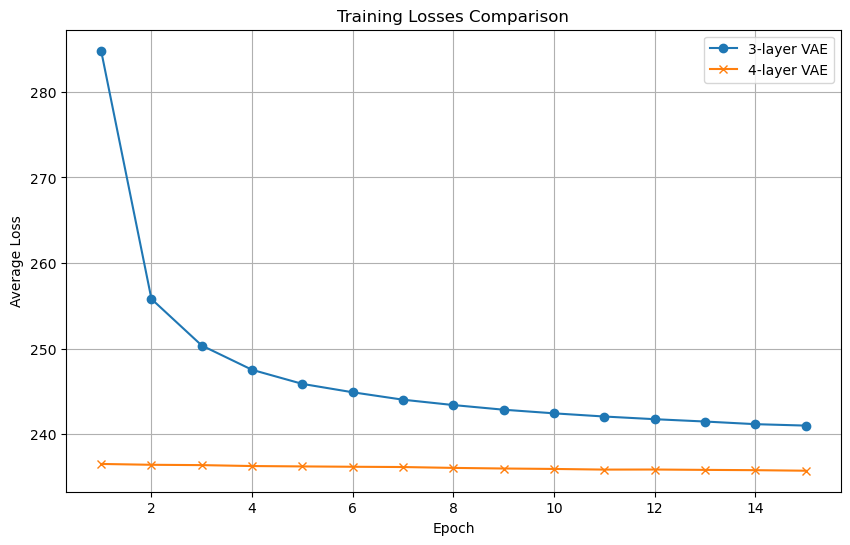

In [21]:
# Compare the final loss of the fully trained old model and the new model
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, final_losses_3, label='3-layer VAE', marker='o')
plt.plot(epochs, final_losses_4, label='4-layer VAE', marker='x')

plt.title('Training Losses Comparison')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()



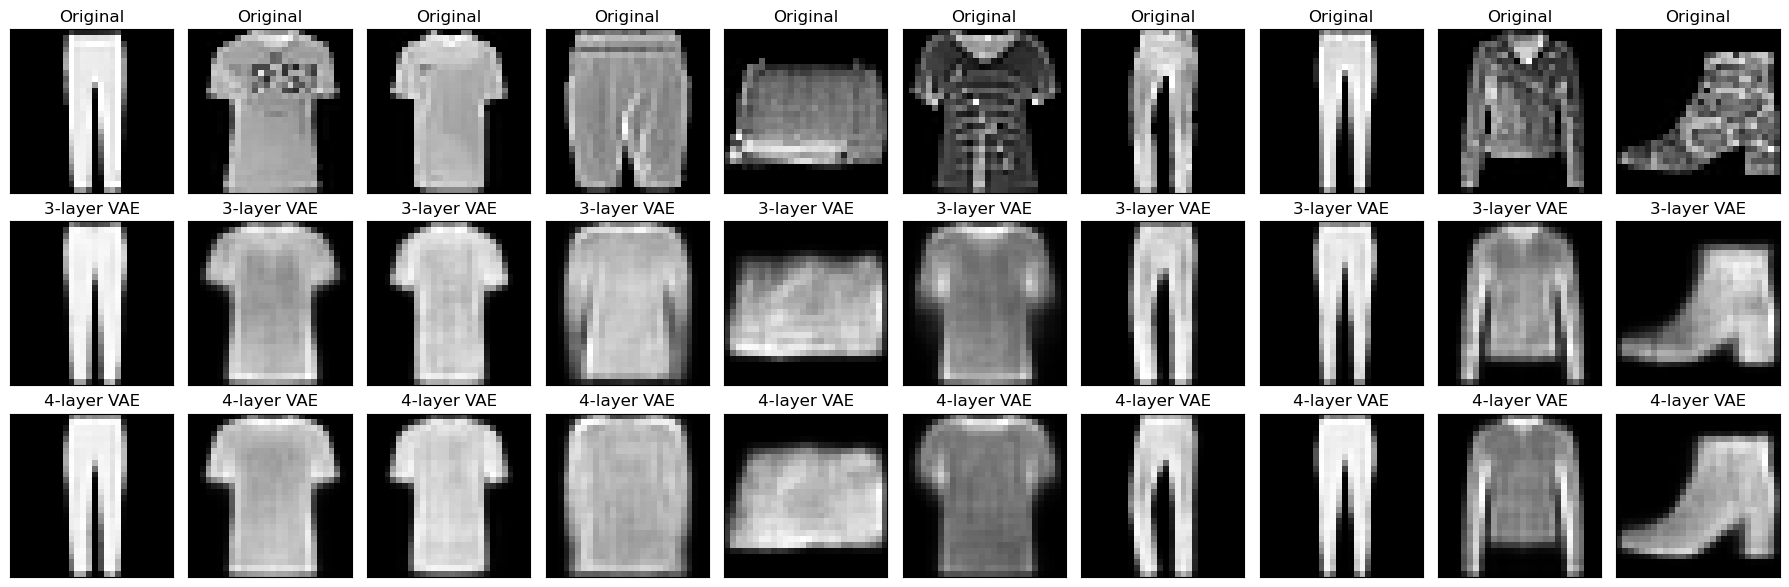

In [23]:
# Compare the reconstructed images from the two models

reconst_image_3_layer, _, _ = model_3(best_image_original)
reconst_image_4_layer, _, _ = model_4(best_image_original)

reconst3 = reconst_image_3_layer.detach();
reconst4 = reconst_image_4_layer.detach();

import matplotlib.pyplot as plt

def plot_comparison(best_image_original, reconst_images_3_layer, reconst_images_4_layer, n=10):
    plt.figure(figsize=(18, 6))
    
    for i in range(n):
        # Display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(best_image_original[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction from 3-layer VAE
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(reconst3[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("3-layer VAE")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction from 4-layer VAE
        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(reconst4[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("4-layer VAE")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

# Assuming x_test is preprocessed appropriately for your model
# (e.g., flattened, normalized, etc., as necessary)
plot_comparison(best_image_original, reconst3, reconst4)


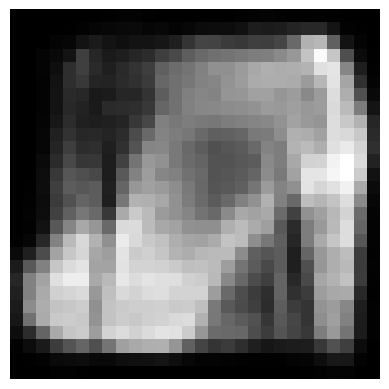

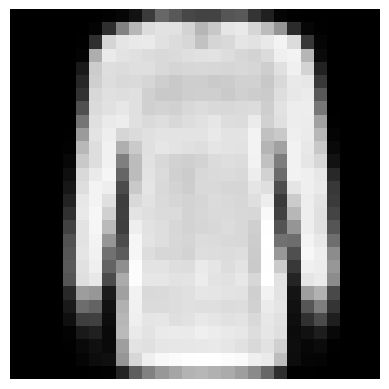

In [30]:
# Compare generate images from the two models
model_3.eval()  # Set the model to evaluation mode

# Sample a latent vector from the Gaussian distribution
z_dim = 20  # Dimension of the latent space
latent = torch.randn(1, z_dim).to(device)  # For generating one image, 'device' is cuda or cpu

# Pass the latent vector through the decoder
with torch.no_grad():  # No need to track gradients
    generated_image_3 = model_3.decode(latent).view(28, 28)

model_4.eval()  # Set the model to evaluation mode

# Sample a latent vector from the Gaussian distribution
#z_dim = 20  # Dimension of the latent space
#latent = torch.randn(1, z_dim).to(device)  # For generating one image, 'device' is cuda or cpu

# Pass the latent vector through the decoder
with torch.no_grad():  # No need to track gradients
    generated_image_4 = model_4.decode(latent).view(28, 28)


# Assuming 'generated_image' is a single-channel image (e.g., grayscale) and normalized [0, 1]
plt.imshow(generated_image_3.cpu().squeeze(), cmap='gray')  # '.cpu()' is used to move tensor to CPU if on GPU
plt.axis('off')  # Hide the axes
plt.show()

# Assuming 'generated_image' is a single-channel image (e.g., grayscale) and normalized [0, 1]
plt.imshow(generated_image_4.cpu().squeeze(), cmap='gray')  # '.cpu()' is used to move tensor to CPU if on GPU
plt.axis('off')  # Hide the axes
plt.show()

## b.
### Change the layers

In this experiment you will change the layers of the VAE using different combinations and compare the results

In [123]:
# Create different 3 layer VAE models with different h-dim and z-dim

# Hyper-parameters
image_size = 784
learning_rate = 1e-3
num_epochs = 15

h_dim_1 = 20
z_dim_1 = 400

model1 = VAE_3(image_size, h_dim_1, z_dim_1).to(device)
optimizer_1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

h_dim_2 = 100
z_dim_2 = 100

model2 = VAE_3(image_size, h_dim_2, z_dim_2).to(device)
optimizer_2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

h_dim_3 = 800
z_dim_3 = 40

model3 = VAE_3(image_size, h_dim_3, z_dim_3).to(device)
optimizer_3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)
    

In [129]:
# Train all models

final_losses1 = []
final_losses2 = []
final_losses3 = []

reconst_min = None
reconst_max = None
best_image_original = None
best_image_reconst = None
bad_image_original = None
bad_image_reconst = None
# Start training
for epoch in range(num_epochs):
    
    epoch_loss_1 = 0.0
    epoch_loss_2 = 0.0
    epoch_loss_3 = 0.0
    
    for i, (x, _) in enumerate(data_loader):
        
        # MODEL 1
        
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst_1, mu_1, log_var_1 = model1(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss_1 = F.binary_cross_entropy(x_reconst_1, x, reduction='sum')
        kl_div_1 = - 0.5 * torch.sum(1 + log_var_1 - mu_1.pow(2) - log_var_1.exp())

        # Backprop and optimize
        loss_1 = reconst_loss_1 + kl_div_1
        optimizer_1.zero_grad()
        loss_1.backward()
        optimizer_1.step()
        
        epoch_loss_1 += loss_1.item()

        if (i+1) % 10 == 0:
            print ("Model 1: Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss_1.item()/len(x), kl_div_1.item()/len(x)))
    
        # MODEL 2
        
        # Forward pass

        x_reconst_2, mu_2, log_var_2 = model2(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss_2 = F.binary_cross_entropy(x_reconst_2, x, reduction='sum')
        kl_div_2 = - 0.5 * torch.sum(1 + log_var_2 - mu_2.pow(2) - log_var_2.exp())

        # Backprop and optimize
        loss_2 = reconst_loss_2 + kl_div_2
        optimizer_2.zero_grad()
        loss_2.backward()
        optimizer_2.step()
        
        epoch_loss_2 += loss_2.item()

        if (i+1) % 10 == 0:
            print ("Model 2: Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss_2.item()/len(x), kl_div_2.item()/len(x)))
    
        # MODEL 3
        
        # Forward pass

        x_reconst_3, mu_3, log_var_3 = model3(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss_3 = F.binary_cross_entropy(x_reconst_3, x, reduction='sum')
        kl_div_3 = - 0.5 * torch.sum(1 + log_var_3 - mu_3.pow(2) - log_var_3.exp())

        # Backprop and optimize
        loss_3 = reconst_loss_3 + kl_div_3
        optimizer_3.zero_grad()
        loss_3.backward()
        optimizer_3.step()
        
        epoch_loss_3 += loss_3.item()
        
        min_reconst_of_three = min(min(reconst_loss_1.item()/len(x), reconst_loss_2.item()/len(x)), reconst_loss_3.item()/len(x))
        max_reconst_of_three = max(max(reconst_loss_1.item()/len(x), reconst_loss_2.item()/len(x)), reconst_loss_3.item()/len(x))
        
        if(reconst_min == None):
            reconst_min = min_reconst_of_three
            best_image_original = x
            best_image_reconst = x_reconst
        elif(min_reconst_of_three < reconst_min):
            reconst_min = min_reconst_of_three
            best_image_original = x
            best_image_reconst = x_reconst

        if(reconst_max == None):
            reconst_max = max_reconst_of_three
            bad_image_original = x
            bad_image_reconst = x_reconst
        elif(max_reconst_of_three > reconst_max):
            reconst_max = max_reconst_of_three
            bad_image_original = x
            bad_image_reconst = x_reconst
        

        if (i+1) % 10 == 0:
            print ("Model 3: Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss_3.item()/len(x), kl_div_3.item()/len(x)))
    
    final_losses1.append(epoch_loss_1 / len(data_loader.dataset))
    final_losses2.append(epoch_loss_2 / len(data_loader.dataset))
    final_losses3.append(epoch_loss_3 / len(data_loader.dataset))

Model 1: Epoch[1/15], Step [10/469], Reconst Loss: 275.8964, KL Div: 12.5471
Model 2: Epoch[1/15], Step [10/469], Reconst Loss: 227.6882, KL Div: 13.8558
Model 3: Epoch[1/15], Step [10/469], Reconst Loss: 219.8653, KL Div: 16.2567
Model 1: Epoch[1/15], Step [20/469], Reconst Loss: 292.1343, KL Div: 12.8716
Model 2: Epoch[1/15], Step [20/469], Reconst Loss: 236.9290, KL Div: 14.7168
Model 3: Epoch[1/15], Step [20/469], Reconst Loss: 229.8754, KL Div: 16.0677
Model 1: Epoch[1/15], Step [30/469], Reconst Loss: 298.3586, KL Div: 11.6465
Model 2: Epoch[1/15], Step [30/469], Reconst Loss: 243.5169, KL Div: 14.2220
Model 3: Epoch[1/15], Step [30/469], Reconst Loss: 236.8272, KL Div: 16.1639
Model 1: Epoch[1/15], Step [40/469], Reconst Loss: 290.0286, KL Div: 13.1304
Model 2: Epoch[1/15], Step [40/469], Reconst Loss: 228.9412, KL Div: 15.4453
Model 3: Epoch[1/15], Step [40/469], Reconst Loss: 220.4863, KL Div: 17.1709
Model 1: Epoch[1/15], Step [50/469], Reconst Loss: 292.3211, KL Div: 12.4668

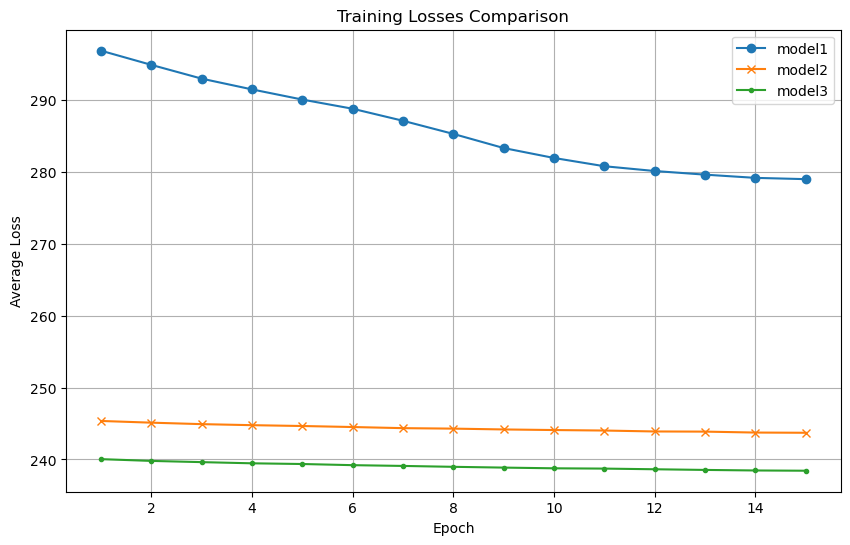

In [130]:
# Compare the models based on their optimal loss

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, final_losses1, label='model1', marker='o')
plt.plot(epochs, final_losses2, label='model2', marker='x')
plt.plot(epochs, final_losses3, label='model3', marker='.')

plt.title('Training Losses Comparison')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()


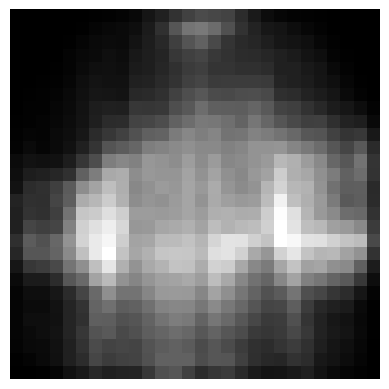

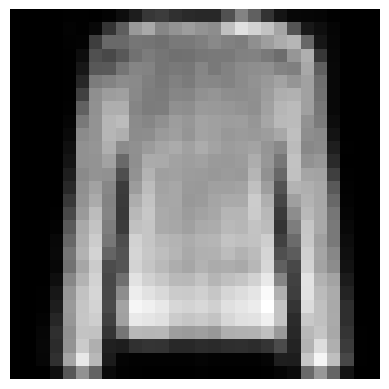

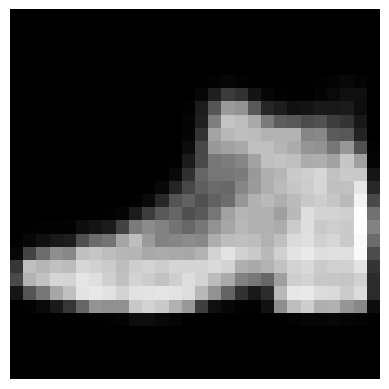

In [134]:
# Compare models based on their generated images (visual inspection)

# Compare generate images from the two models
model1.eval()  # Set the model to evaluation mode
model2.eval()  # Set the model to evaluation mode
model3.eval()  # Set the model to evaluation mode

# Sample a latent vector from the Gaussian distribution
# Dimension of the latent space
latent_1 = torch.randn(1, z_dim_1).to(device)  # For generating one image, 'device' is cuda or cpu
latent_2 = torch.randn(1, z_dim_2).to(device)  # For generating one image, 'device' is cuda or cpu
latent_3 = torch.randn(1, z_dim_3).to(device)  # For generating one image, 'device' is cuda or cpu


# Pass the latent vector through the decoder
with torch.no_grad():  # No need to track gradients
    generated_image1 = model1.decode(latent_1).view(28, 28)

# Pass the latent vector through the decoder
with torch.no_grad():  # No need to track gradients
    generated_image2 = model2.decode(latent_2).view(28, 28)

# Pass the latent vector through the decoder
with torch.no_grad():  # No need to track gradients
    generated_image3 = model3.decode(latent_3).view(28, 28)


# Assuming 'generated_image' is a single-channel image (e.g., grayscale) and normalized [0, 1]
plt.imshow(generated_image1.cpu().squeeze(), cmap='gray')  # '.cpu()' is used to move tensor to CPU if on GPU
plt.axis('off')  # Hide the axes
plt.show()

# Assuming 'generated_image' is a single-channel image (e.g., grayscale) and normalized [0, 1]
plt.imshow(generated_image2.cpu().squeeze(), cmap='gray')  # '.cpu()' is used to move tensor to CPU if on GPU
plt.axis('off')  # Hide the axes
plt.show()

# Assuming 'generated_image' is a single-channel image (e.g., grayscale) and normalized [0, 1]
plt.imshow(generated_image3.cpu().squeeze(), cmap='gray')  # '.cpu()' is used to move tensor to CPU if on GPU
plt.axis('off')  # Hide the axes
plt.show()

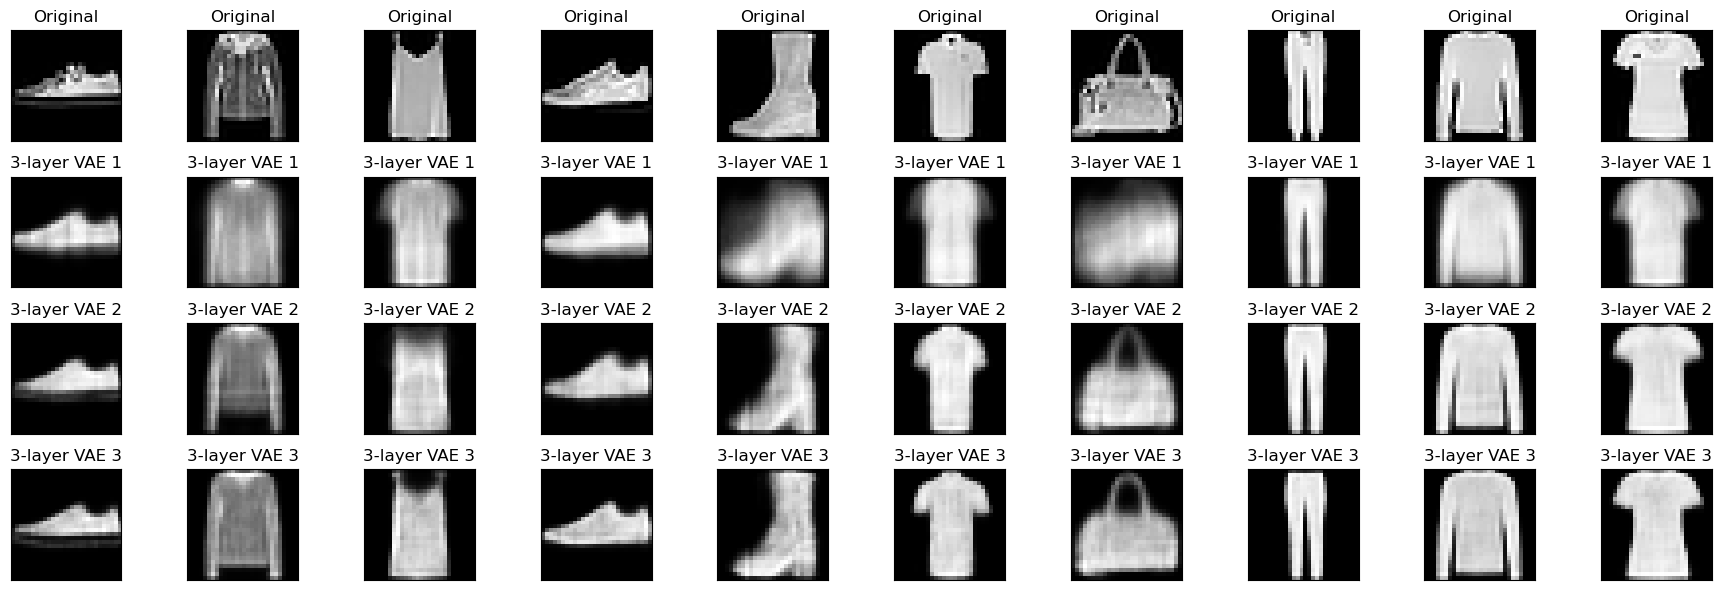

In [135]:
# Compare models based on their regenerated images (visual inspection)


reconst_image_1_layer, _, _ = model1(bad_image_original)
reconst_image_2_layer, _, _ = model2(bad_image_original)
reconst_image_3_layer, _, _ = model3(bad_image_original)

reconst1 = reconst_image_1_layer.detach();
reconst2 = reconst_image_2_layer.detach();
reconst3 = reconst_image_3_layer.detach();

def plot_comparison(bad_image_original, reconst_images_1_layer, reconst_images_2_layer, reconst_images_3_layer, n=10):
    plt.figure(figsize=(18, 6))
    
    for i in range(n):
        # Display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(bad_image_original[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction from 3-layer VAE
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(reconst1[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("3-layer VAE 1")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction from 3-layer VAE
        ax = plt.subplot(4, n, i + 1 + n * 2)
        plt.imshow(reconst2[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("3-layer VAE 2")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction from 3-layer VAE
        ax = plt.subplot(4, n, i + 1 + n*3)
        plt.imshow(reconst3[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("3-layer VAE 3")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

# Assuming x_test is preprocessed appropriately for your model
# (e.g., flattened, normalized, etc., as necessary)
plot_comparison(bad_image_original, reconst1, reconst2, reconst3)


## c.
### Create a Normal Autoencoder

In this experiment you will convert the current model into an autoencoder

In [142]:
# Convert the VAE class into an 3layer autoencoder
class SimpleAutoencoder(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(SimpleAutoencoder, self).__init__()
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, z_dim)
        )
        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()  # Assuming the input is normalized between 0 and 1
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [154]:
# Create the autoenocder model
# Hyper-parameters
image_size = 784
learning_rate = 1e-3
num_epochs = 15

ae_h_dim_1 = 800
ae_z_dim_1 = 40

ae_model1 = SimpleAutoencoder(image_size, ae_h_dim_1, ae_z_dim_1).to(device)
ae_optimizer_1 = torch.optim.Adam(ae_model1.parameters(), lr=learning_rate)



In [155]:
ae_final_loss = []

for epoch in range(num_epochs):
    total_loss = 0  # Initialize total loss for the epoch
    for x, _ in data_loader:  # Iterate over the dataset
        x = x.to(device).view(-1, image_size)  # Prepare the input tensor
        
        # Forward pass: Compute the reconstruction from the autoencoder
        output = ae_model1(x)
        
        # Compute the reconstruction loss; assuming binary cross-entropy
        loss = F.binary_cross_entropy(output, x, reduction='sum')
        
        # Backward pass and optimize
        ae_optimizer_1.zero_grad()  # Zero the gradients to prepare for .backward()
        loss.backward()  # Compute the gradients
        ae_optimizer_1.step()  # Update the model parameters
        
        total_loss += loss.item()  # Accumulate the loss
        
    # After completing the epoch, calculate the average loss
    avg_loss = total_loss / len(data_loader.dataset)
    
    # Print the average loss for the epoch
    print("Epoch [{}/{}], Avg Reconst Loss: {:.4f}".format(epoch+1, num_epochs, avg_loss))
    ae_final_loss.append(avg_loss)


Epoch [1/15], Avg Reconst Loss: 247.6280
Epoch [2/15], Avg Reconst Loss: 220.3223
Epoch [3/15], Avg Reconst Loss: 215.1253
Epoch [4/15], Avg Reconst Loss: 212.3962
Epoch [5/15], Avg Reconst Loss: 210.6512
Epoch [6/15], Avg Reconst Loss: 209.4221
Epoch [7/15], Avg Reconst Loss: 208.5560
Epoch [8/15], Avg Reconst Loss: 207.9065
Epoch [9/15], Avg Reconst Loss: 207.3862
Epoch [10/15], Avg Reconst Loss: 206.9861
Epoch [11/15], Avg Reconst Loss: 206.6101
Epoch [12/15], Avg Reconst Loss: 206.3008
Epoch [13/15], Avg Reconst Loss: 206.0675
Epoch [14/15], Avg Reconst Loss: 205.8031
Epoch [15/15], Avg Reconst Loss: 205.6141


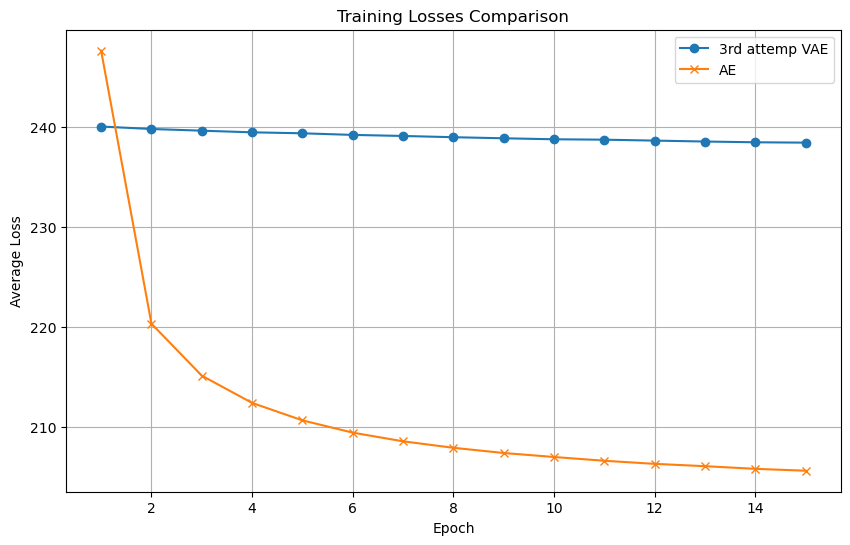

In [156]:
# Compare the models based on their optimal loss

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, final_losses3, label='3rd attemp VAE', marker='o')
plt.plot(epochs, ae_final_loss, label='AE', marker='x')

plt.title('Training Losses Comparison')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

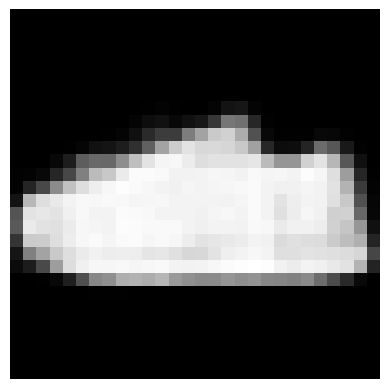

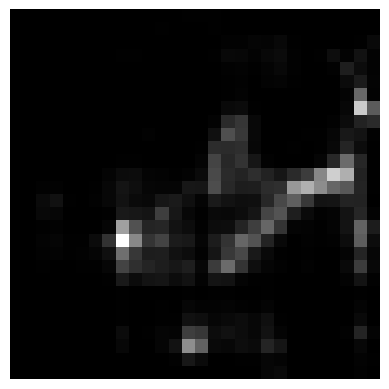

In [176]:
# Compare models based on their generated images (visual inspection)
# Compare models based on their generated images (visual inspection)

# Compare generate images from the two models

model3.eval()  # Set the model to evaluation mode
ae_model1.eval()

# Sample a latent vector from the Gaussian distribution
# Dimension of the latent space
z_dim = 40
latent = torch.randn(1, z_dim).to(device)  # For generating one image, 'device' is cuda or cpu

# Pass the latent vector through the decoder
with torch.no_grad():  # No need to track gradients
    generated_image_vae = model3.decode(latent).view(28, 28)

# Pass the latent vector through the decoder
with torch.no_grad():  # No need to track gradients
    generated_image_ae = ae_model1.decoder(latent).view(28, 28)



# Assuming 'generated_image' is a single-channel image (e.g., grayscale) and normalized [0, 1]
plt.imshow(generated_image_vae.cpu().squeeze(), cmap='gray')  # '.cpu()' is used to move tensor to CPU if on GPU
plt.axis('off')  # Hide the axes
plt.show()

# Assuming 'generated_image' is a single-channel image (e.g., grayscale) and normalized [0, 1]
plt.imshow(generated_image_ae.cpu().squeeze(), cmap='gray')  # '.cpu()' is used to move tensor to CPU if on GPU
plt.axis('off')  # Hide the axes
plt.show()


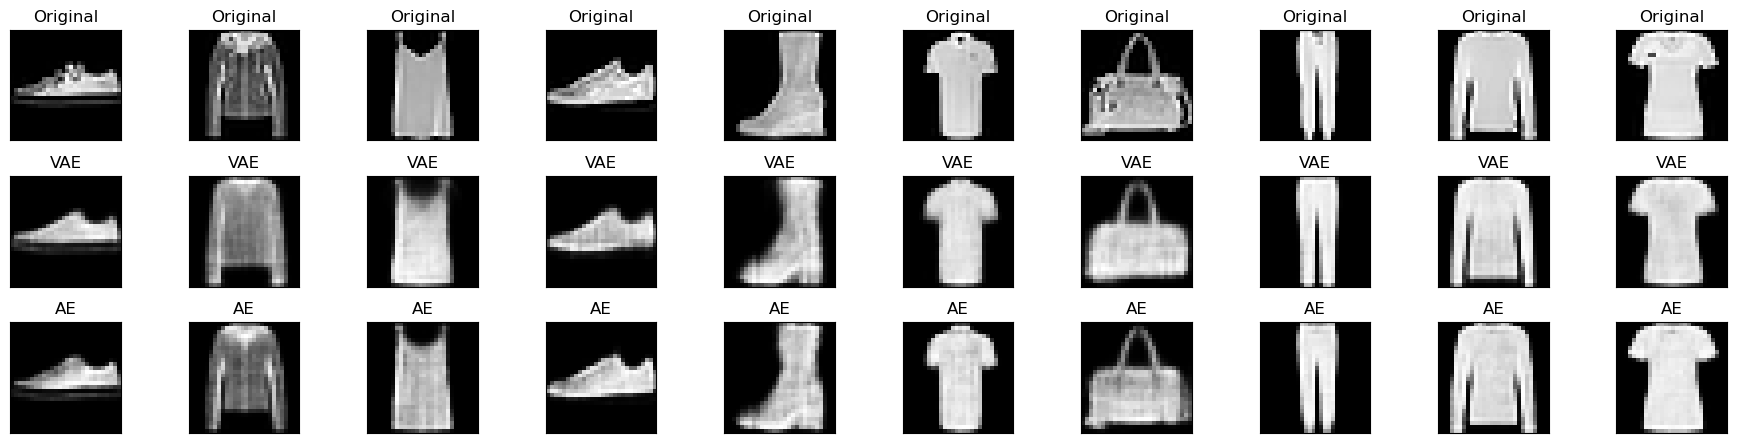

In [180]:
# Compare models based on their regenerated images (visual inspection)


reconst_image_layer_vae, _, _ = model3(bad_image_original)

reconst1 = reconst_image_layer_vae.detach();
reconst2 =  ae_model1(bad_image_original)

def plot_comparison(bad_image_original, n=10):
    plt.figure(figsize=(18, 6))
    
    for i in range(n):
        # Display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(bad_image_original[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction from 3-layer VAE
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(reconst1[i].reshape(28, 28).cpu().numpy(), cmap='gray')
        plt.title("VAE")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction from 3-layer VAE
        ax = plt.subplot(4, n, i + 1 + n * 2)
        plt.imshow(reconst2[i].reshape(28, 28).detach().cpu().numpy(), cmap='gray')
        plt.title("AE")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

# Assuming x_test is preprocessed appropriately for your model
# (e.g., flattened, normalized, etc., as necessary)
plot_comparison(bad_image_original)

## References
1. https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb